In [1]:
# Gini3d_Within_Plume

import numpy as np
from numpy import ma
import math
import scipy
import scipy.constants as constants
import os
from IPython.display import Image

from netCDF4 import Dataset

from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
from matplotlib import ticker

import pandas as pd
import datetime
from tqdm import tqdm
# from matplotlib.mlab import bivariate_normal

NA = 6.022e+23

In [2]:
# Lagrange: 2x2.5

FILEDIR0 = '/n/home12/hongwei/HONGWEI/GC_run_13.0/1_plume_in_60deg/final/Gini/gc_2x25_lagrange_final/OutputDir'

NcFile0   = Dataset(FILEDIR0+'/GEOSChem.SpeciesConc.201501_02.nc4','r',format='NETCDF4_CLASSIC')
lat0             = NcFile0.variables['lat'][:]
lon0             = NcFile0.variables['lon'][:]
LA0              = NcFile0.variables['SpeciesConc_PASV_LA'][:,:,:,:]
LA0_3            = NcFile0.variables['SpeciesConc_PASV_LA3'][:,:,:,:]

LA0 = LA0 + LA0_3


NcFile00   = Dataset(FILEDIR0+'/GEOSChem.StateMet.201501_02.nc4','r',format='NETCDF4_CLASSIC')
GC_V00 = NcFile00.variables['Met_AIRVOL'][:,:,:,:] # [m3]
GC_V00 = GC_V00*1e6 # [m3]=>[cm3]

GC_AD00 = NcFile00.variables['Met_AD'][:,:,:,:] # [kg]
GC_AD00 = GC_AD00*1000.0/28.97 # change [kg] to [mol]



# Lagrange: 2x2.5
FILEDIR1 = '/n/home12/hongwei/HONGWEI/GC_run_13.0/1_plume_in_60deg/final/Gini/gc_2x25_lagrange_final/OutputDir'

NcFile1   = Dataset(FILEDIR1+'/GEOSChem.SpeciesConc.201501_02.nc4','r',format='NETCDF4_CLASSIC')
lat1             = NcFile1.variables['lat'][:]
lon1             = NcFile1.variables['lon'][:]
LA1              = NcFile1.variables['SpeciesConc_PASV_LA'][:,:,:,:]


NcFile11   = Dataset(FILEDIR1+'/GEOSChem.StateMet.201501_02.nc4','r',format='NETCDF4_CLASSIC')
GC_V11 = NcFile11.variables['Met_AIRVOL'][:,:,:,:] # [m3]
GC_V11 = GC_V11*1e6 # [m3]=>[cm3]

GC_AD11 = NcFile11.variables['Met_AD'][:,:,:,:] # [kg]
GC_AD11 = GC_AD11*1000.0/28.97 # change [kg] to [mol]



# Eulerian: 2x2.5
FILEDIR3 = '/n/home12/hongwei/HONGWEI/GC_run_13.0/1_plume_in_60deg/final/Gini/gc_2x25_eulerian_final/OutputDir'

NcFile3   = Dataset(FILEDIR3+'/GEOSChem.SpeciesConc.201501_02.nc4','r',format='NETCDF4_CLASSIC')
lat3             = NcFile3.variables['lat'][:]
lon3             = NcFile3.variables['lon'][:]
EU3              = NcFile3.variables['SpeciesConc_PASV_EU'][:,:,:,:]

NcFile33   = Dataset(FILEDIR3+'/GEOSChem.StateMet.201501_02.nc4','r',format='NETCDF4_CLASSIC')
GC_V33 = NcFile33.variables['Met_AIRVOL'][:,:]
GC_V33 = GC_V33*1e6 # [m3]=>[cm3]

GC_AD33 = NcFile33.variables['Met_AD'][:,:,:,:] # [kg]
GC_AD33 = GC_AD33*1000.0/28.97 # change [kg] to [mol]


In [3]:
Nx = len(LA0[0,0,0,:])
Ny = len(LA0[0,0,:,0])
Nz = len(LA0[0,:,0,0])
Nt = len(LA0[:,0,0,0])

In [4]:
# 2 time step moving average for Met data
GC_V0 = LA0*0.0
GC_AD0 = LA0*0.0

GC_V1 = LA1*0.0
GC_AD1 = LA1*0.0

GC_V3 = LA0*0.0
GC_AD3 = LA0*0.0

for i in range(Nt):
    GC_V0[i,:,:,:]  = (GC_V00[i,:,:,:]+GC_V00[i+1,:,:,:])/2
    GC_AD0[i,:,:,:] = (GC_AD00[i,:,:,:]+GC_AD00[i+1,:,:,:])/2
    
    GC_V1[i,:,:,:]  = (GC_V11[i,:,:,:]+GC_V11[i+1,:,:,:])/2
    GC_AD1[i,:,:,:] = (GC_AD11[i,:,:,:]+GC_AD11[i+1,:,:,:])/2
    
    GC_V3[i,:,:,:]  = (GC_V33[i,:,:,:]+GC_V33[i+1,:,:,:])/2
    GC_AD3[i,:,:,:] = (GC_AD33[i,:,:,:]+GC_AD33[i+1,:,:,:])/2

In [5]:
LA0_mol = LA0[:,:,:,:]*GC_AD0[:,:,:,:] # [mol]
LA1_mol = LA1[:,:,:,:]*GC_AD1[:,:,:,:] # [mol]
EU3_mol = EU3[:,:,:,:]*GC_AD3[:,:,:,:] # [mol]

LA0_C   = LA0_mol[:,:,:,:]/GC_V0[:,:,:,:] # [mol/cm3]
LA1_C   = LA1_mol[:,:,:,:]/GC_V1[:,:,:,:] # [mol/cm3]
EU3_C   = EU3_mol[:,:,:,:]/GC_V3[:,:,:,:]

In [6]:
np.sum(EU3_mol[0,:,:,:])*98/1000 # [kg]

180145.57225

In [7]:
Nt = 21

In [8]:
# (1) GEOS-Chem

EU3_V_cumsum_frac_time = []
EU3_mass_cumsum_frac_time = []


for it in range(Nt):
    # concentration
    EU3_C_1D = EU3_C[it,:,:,:].reshape(Nx*Ny*Nz)
     
    # mass
    EU3_mol_1D = EU3_mol[it,:,:,:].reshape(Nx*Ny*Nz)

    # grid cell volume
    GC_V3_1D = GC_V3[it,:,:,:].reshape(Nx*Ny*Nz)

    # get index for sorted concentration
    EU3_index = EU3_C_1D.argsort()
    EU3_C_sorted = EU3_C_1D[EU3_index]
    EU3_V_sorted = GC_V3_1D[EU3_index]
    EU3_mass_sorted = EU3_mol_1D[EU3_index]

    # cumulative sum
    EU3_V_cumsum = np.cumsum(EU3_V_sorted)
    EU3_mass_cumsum = np.cumsum(EU3_mass_sorted)

    # calculate fraction
    length3 = len(EU3_V_cumsum)
    EU3_V_cumsum_frac = EU3_V_cumsum/EU3_V_cumsum[length3-1]
    EU3_mass_cumsum_frac = EU3_mass_cumsum/EU3_mass_cumsum[length3-1]

    EU3_V_cumsum_frac_time.append(EU3_V_cumsum_frac)
    EU3_mass_cumsum_frac_time.append(EU3_mass_cumsum_frac)


In [9]:
# (2) PiG model: Instant Dilution in Post_process

LA0_V_cumsum_frac_time = []
LA0_mass_cumsum_frac_time = []


for it in range(Nt):
    # concentration
    LA0_C_1D = LA0_C[it,:,:,:].reshape(Nx*Ny*Nz)
     
    # mass
    LA0_mol_1D = LA0_mol[it,:,:,:].reshape(Nx*Ny*Nz)

    # grid cell volume
    GC_V0_1D = GC_V0[it,:,:,:].reshape(Nx*Ny*Nz)

    # get index for sorted concentration
    LA0_index = LA0_C_1D.argsort()
    LA0_C_sorted = LA0_C_1D[LA0_index]
    LA0_V_sorted = GC_V0_1D[LA0_index]
    LA0_mass_sorted = LA0_mol_1D[LA0_index]

    # cumulative sum
    LA0_V_cumsum = np.cumsum(LA0_V_sorted)
    LA0_mass_cumsum = np.cumsum(LA0_mass_sorted)

    # calculate fraction
    length0 = len(LA0_V_cumsum)
    LA0_V_cumsum_frac = LA0_V_cumsum/LA0_V_cumsum[length0-1]
    LA0_mass_cumsum_frac = LA0_mass_cumsum/LA0_mass_cumsum[length0-1]

    LA0_V_cumsum_frac_time.append(LA0_V_cumsum_frac)
    LA0_mass_cumsum_frac_time.append(LA0_mass_cumsum_frac)

In [10]:
# output the min and max volume for Eulerian grid cells
np.max(GC_V1[:,:,:,:]), np.min(GC_V1[:,:,:,:]), np.sum(LA1_mol)

(2.6324279e+20, 2.2337324e+16, 91695336.0)

In [11]:
# (3) PiG model: No Instant Dilution in Post_process

LA1_V_cumsum_frac_time = []
LA1_mass_cumsum_frac_time = []

date1 = datetime.date(2015, 1, 1)
delta = datetime.timedelta(days=1)

for it in range(Nt):
    
    if it<=19:
        date1 = date1 + delta

        date1_name = datetime.datetime.strftime(date1, '%Y-%-m-%-d')

        Dir = '/n/home12/hongwei/HONGWEI/GC_run_13.0/1_plume_in_60deg/final/Gini/gc_2x25_lagrange_final'
        file1_name = Dir+'/Lagrange_Concnt_Volume_'+date1_name+'-0:0:0.txt'
    
    
        df1 = pd.read_fwf(file1_name, header=None, sep=" ")
        df1.columns   = ["i_lon","i_lat","i_lev","Concnt","Volume"] # [molec/cm3], [cm3]
        df1['Concnt'] = pd.to_numeric(df1['Concnt'], errors='coerce')
        
        # replace all the nan with 0
        df1['Concnt'] = df1['Concnt'].fillna(0)

        Plume_C_old = df1['Concnt']/NA  # [mol/cm3]
        Plume_V_old = df1['Volume']     # [cm3]
        Plume_M_old = Plume_C_old*Plume_V_old   # [mol]
        
        
        Plume_C, Plume_V, Plume_M = [],[],[]
        
        
        for i_cell in tqdm(range(len(df1))):
            i_lon = df1[i_cell:i_cell+1]['i_lon']-1 # index in Fortran begins at 1, in python begins at 0
            i_lat = df1[i_cell:i_cell+1]['i_lat']-1
            i_lev = df1[i_cell:i_cell+1]['i_lev']-1
            
            
            if Plume_C_old[i_cell:i_cell+1].values>LA1_C[it,i_lev,i_lat,i_lon]:
                Plume_C.append(Plume_C_old[i_cell:i_cell+1] + LA1_C[it,i_lev,i_lat,i_lon])
                Plume_V.append(Plume_V_old[i_cell:i_cell+1])
                Plume_M.append(Plume_M_old[i_cell:i_cell+1])
                GC_V1[it,i_lev,i_lat,i_lon] = GC_V1[it,i_lev,i_lat,i_lon] - Plume_V_old[i_cell:i_cell+1].values
            else:
                LA1_mol[it,i_lev,i_lat,i_lon] = LA1_mol[it,i_lev,i_lat,i_lon]+Plume_M_old[i_cell:i_cell+1].values
                LA1_C[it,i_lev,i_lat,i_lon] = LA1_mol[it,i_lev,i_lat,i_lon]/GC_V1[it,i_lev,i_lat,i_lon]
            
    # Check for the negative volume in GEOS-Chem grid cell
    
    
    # grid cell concentration, mass, volume
    LA1_C_1D   = LA1_C[it,:,:,:].reshape(Nx*Ny*Nz)
    LA1_mol_1D = LA1_mol[it,:,:,:].reshape(Nx*Ny*Nz)
    GC_V1_1D   = GC_V1[it,:,:,:].reshape(Nx*Ny*Nz)
    
    if it<=19:
        LA1_C_1D   = np.concatenate((LA1_C_1D, np.squeeze(np.array(Plume_C))))
        LA1_mol_1D = np.concatenate((LA1_mol_1D, np.squeeze(np.array(Plume_M))))
        GC_V1_1D   = np.concatenate((GC_V1_1D, np.squeeze(np.array(Plume_V))))

        
    d = {'Concnt_mol_cm3':LA1_C_1D, 'Volume_cm3':GC_V1_1D,  'Mass_mol':LA1_mol_1D}
    df0 = pd.DataFrame(data=d)
    df0.to_csv('Gini_All_Grid_Cell_GEOS-Chem_Plume'+date1_name+'-0:0:0.csv', index = False)
    
    
    df00 = pd.read_csv('Gini_All_Grid_Cell_GEOS-Chem_Plume'+date1_name+'-0:0:0.csv', sep=",")
    LA1_C_1D   = df00['Concnt_mol_cm3'].values
    GC_V1_1D   = df00['Volume_cm3'].values
    LA1_mol_1D = df00['Mass_mol'].values
    
    
    
    # get index for sorted concentration
    LA1_index = LA1_C_1D.argsort()
    LA1_C_sorted = LA1_C_1D[LA1_index]
    LA1_V_sorted = GC_V1_1D[LA1_index]
    LA1_mass_sorted = LA1_mol_1D[LA1_index]

    # cumulative sum
    LA1_V_cumsum = np.cumsum(LA1_V_sorted)
    LA1_mass_cumsum = np.cumsum(LA1_mass_sorted)

    # calculate fraction
    length0 = len(LA1_V_cumsum)
    LA1_V_cumsum_frac = LA1_V_cumsum/LA1_V_cumsum[length0-1]
    LA1_mass_cumsum_frac = LA1_mass_cumsum/LA1_mass_cumsum[length0-1]

    LA1_V_cumsum_frac_time.append(LA1_V_cumsum_frac)
    LA1_mass_cumsum_frac_time.append(LA1_mass_cumsum_frac)

100%|██████████| 120/120 [00:00<00:00, 613.41it/s]


ValueError: Length mismatch: Expected axis has 2 elements, new values have 5 elements

In [ ]:
np.argwhere(np.isnan(LA1_mol_1D))

In [ ]:

np.argwhere(np.isnan(Plume_C_old.values))

In [ ]:
Plume_V_old.values

In [ ]:
np.nansum(LA1_mol_1D)

In [ ]:
print(np.sum(np.array(Plume_M)), np.sum(LA1_mol_1D), np.sum(LA0_mol_1D), len(Plume_M), len(Plume_C))

In [ ]:
LA1_mol_1D

In [ ]:
print(np.sum(Plume_V), np.sum(GC_V1_1D), np.sum(GC_V0_1D))

In [ ]:
len(EU3_mass_cumsum)

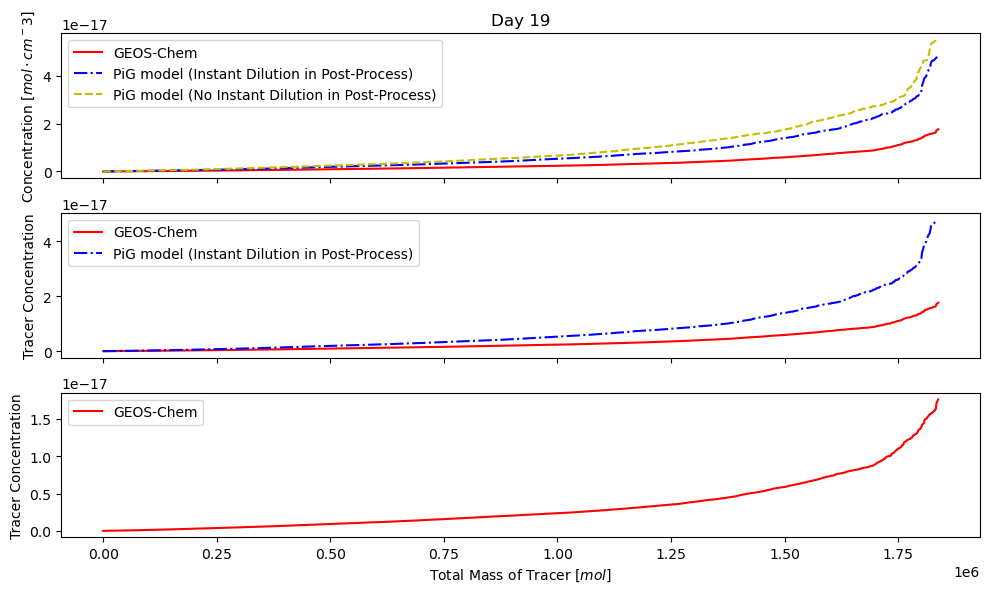

In [12]:
figure, axs = plt.subplots(3,1, sharex=True, figsize=(10,6), dpi=100)


# (1)
begin = 1
axs[0].plot(EU3_mass_cumsum[begin::], EU3_C_sorted[begin::], 'r-', label='GEOS-Chem')
axs[0].plot(LA0_mass_cumsum[begin::], LA0_C_sorted[begin::], 'b-.', label='PiG model (Instant Dilution in Post-Process)')
axs[0].plot(LA1_mass_cumsum[begin::], LA1_C_sorted[begin::], 'y--', label='PiG model (No Instant Dilution in Post-Process)')

# axs[0].set_yscale('log')

# axs[0].set_xlabel(f'Total Mass of Tracer [$mol$]')
axs[0].set_ylabel(f'Concentration [$mol \cdot cm^{-3}$]')
axs[0].set_title(f'Day {it}')
axs[0].legend();

# (2)
axs[1].plot(EU3_mass_cumsum[begin::], EU3_C_sorted[begin::], 'r-', label='GEOS-Chem')
axs[1].plot(LA0_mass_cumsum[begin::], LA0_C_sorted[begin::], 'b-.', label='PiG model (Instant Dilution in Post-Process)')

# plt.yscale('log')

# axs[1].set_xlabel(f'Total Mass of Tracer [$mol$]')
axs[1].set_ylabel(f'Tracer Concentration');
axs[1].legend();


# (3)
axs[2].plot(EU3_mass_cumsum[begin::], EU3_C_sorted[begin::], 'r-', label='GEOS-Chem')
# axs[2].plot(LA0_mass_cumsum[begin::], LA0_C_sorted[begin::], 'b-.', label='PiG model (Instant Dilution in Post-Process)')

# plt.yscale('log')

axs[2].set_xlabel(f'Total Mass of Tracer [$mol$]')
axs[2].set_ylabel(f'Tracer Concentration');
axs[2].legend();

plt.tight_layout()

In [ ]:
plt.plot(EU3_C_sorted,'.')

In [ ]:
plt.plot(LA1_C_sorted,'.')

In [ ]:
plt.plot(Plume_C,'.')

In [ ]:
# Plot CFD curve: mass vs. area in the END of the simulation
plt.figure(figsize=(6,4), dpi= 100)

it = 0

plt.plot(EU3_V_cumsum_frac_time[it],EU3_mass_cumsum_frac_time[it],'b',label=f'GEOS-Chem')

plt.plot(LA0_V_cumsum_frac_time[it],LA0_mass_cumsum_frac_time[it],'r--',label=f'PiG with instant dilution Post-process')
plt.plot(LA1_V_cumsum_frac_time[it],LA1_mass_cumsum_frac_time[it],'b--',label=f'PiG without instant dilution Post-process')

diag = np.linspace(0,1,30)
plt.plot(diag,diag,'k')

plt.plot(0*diag+1,diag,'k--', alpha=0.6)
plt.plot(diag,0*diag,'k--', alpha=0.6)


# plt.text(0.57, 0.32, '$S_1$', fontsize=12)
# plt.text(0.73, 0.2, '$S_2$', fontsize=12)
# plt.text(0.87, 0.1, '$S_3$', fontsize=12)


#plt.legend(loc='upper left')
# plt.title(' Cumulative Fraction from Lower to Higher Concentration')
plt.xlabel('Cumulative Volume Fraction', fontsize=12)
plt.ylabel('Cumulative Mass Fraction', fontsize=12)
plt.title(f'Gin3D on Day={it}', fontsize=12)
plt.legend();

# plt.savefig('CDF_Area_Mass.png')

In [ ]:
# calculate Gini coefficient

Gini_Eu3_time,Gini_La0_time,Gini_La1_time = [],[],[]

for it in range(Nt):
    diag = np.linspace(0,1,100)
    Al = np.trapz(diag, diag)

    EU3 = np.trapz(EU3_mass_cumsum_frac_time[it], EU3_V_cumsum_frac_time[it])
    LA0 = np.trapz(LA0_mass_cumsum_frac_time[it], LA0_V_cumsum_frac_time[it])
    LA1 = np.trapz(LA1_mass_cumsum_frac_time[it], LA1_V_cumsum_frac_time[it])

    Gini_Eu3 = (Al-EU3)/Al
    Gini_La0 = (Al-LA0)/Al
    Gini_La1 = (Al-LA1)/Al

    Gini_Eu3_time.append(Gini_Eu3)
    Gini_La0_time.append(Gini_La0)
    Gini_La1_time.append(Gini_La1)

    
print(Al)
print('Gini_La_Eu')
print(Gini_Eu3)
print(Gini_La1)

In [ ]:
figure = plt.figure(figsize=(6,3), dpi=100)

plt.plot(Gini_Eu3_time,'r--', label='GEOS-Chem')
plt.plot(Gini_La0_time,'b', label='PiG with instant dilution post-process')
plt.plot(Gini_La1_time,'y--', label='PiG without instant dilution post-process')

plt.ylabel('Gini 3D', fontsize=12)
plt.xlabel('Day')
plt.legend();

In [ ]:
figure = plt.figure(figsize=(6,3), dpi=100)

plt.plot(Gini_Eu3_time[0:10],'k', label='GEOS-Chem')
plt.plot(Gini_La0_time[0:10],'b', label='PiG with instant dilution post-process')
plt.plot(Gini_La1_time[0:10],'r--', label='PiG without instant dilution post-process')

plt.ylabel('Gini 3D', fontsize=12)
plt.xlabel('Day')
plt.legend();

In [ ]:
Dir = '/n/home12/hongwei/HONGWEI/GC_run_13.0/1_plume_in_60deg/final/Gini/gc_2x25_lagrange_final'
file1_name = Dir+'/Lagrange_Concnt_Volume_2015-1-2-0:0:0.txt'
    
    
df1 = pd.read_fwf(file1_name, header=None, sep=" ")
df1.columns = ["i_lon","i_lat","i_lev","Concnt", "Volume"] # [molec/cm3], [cm3]
df1[0:243*117]

In [ ]:
# df1['Concnt'].astype('float')
df1['Concnt'] = pd.to_numeric(df1['Concnt'], errors='coerce')
df1['Concnt'][0:243*117]

In [ ]:
df2 = df1[ df1['Concnt'] != 0 ] 
df2

In [ ]:
len(df1), len(df2)

In [ ]:
df1["Volume"]

In [ ]:
df1[0:243*117]

In [ ]:
df1.shape

In [ ]:
 len(df1)

In [ ]:
df1[0:1]['i_lon']

In [ ]:
df1['Volume'].sum()

In [ ]:
plt.plot(df1['Concnt'][0:243*117],'.');

In [ ]:
c = df1['Concnt'][0:243*117]
v = df1['Volume'][0:243*117]
np.sum(c*v)/NA, np.sum(c*v)/NA*98/1000 # [kg]

In [ ]:
c = df1['Concnt']
v = df1['Volume']
np.sum(c*v)/NA*98/1000 # [kg]

In [ ]:
# np.sum(EU3_mol[0,:,:,:])*98/1000 # [kg]

In [ ]:
df1 = pd.DataFrame(C1d_center)
df1.to_csv('C1d_center_time_series_10min.txt', index = False)

In [ ]:
d = {'col1': df1['Concnt'], 'col2': df1['Volume']}
df0 = pd.DataFrame(data=d)
df0.to_csv('All_Grid_Cell_GEOS-Chem_Plume.txt', index = False)

In [ ]:
df0

In [ ]:
Dir = '/n/home12/hongwei/HONGWEI/GC_Python/Paper1_plot'
file1_name = Dir+'/Gini_All_Grid_Cell_GEOS-Chem_Plume2015-1-2-0:0:0.csv'
    
    
df1 = pd.read_csv(file1_name, sep=",")
df1

In [ ]:
LA1_C_1D = df1['Concnt_mol_cm3'].values

LA1_C_1D[1:-1].shape

In [ ]:
LA1_C_1D = df1['Concnt_mol_cm3'].values
LA1_index = LA1_C_1D.argsort()
LA1_C_sorted = LA1_C_1D[LA1_index]
LA1_C_sorted

In [ ]:
df1['Mass_mol'].min(), df1['Mass_mol'].max(), df1['Mass_mol'].sum()

In [ ]:
df1['Volume_cm3'].min(), df1['Volume_cm3'].max()

In [ ]:
np.sum(df1['Mass_mol'])